In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.ref_book import ReferenceBookAnonymization

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на обезличенном датасете i2b2 2014 без учёта регистра

### Этап 3: Демонстрация качества искусственных примеров личных сущностей
Правдоподобность искусственных примеров будет оцениваться по метрикам их определения лучшей NER моделью --- BERT-large-uncased, дообученной на i2b2 2014

In [7]:
# Инициализация алгоритма генерации искусственных сущностей на основе справочника
anonymization = ReferenceBookAnonymization(anon_config['path_to_first_male_names'],
                                           anon_config['path_to_first_femail_names'],
                                           anon_config['path_to_last_names'],
                                           anon_config['path_to_full_addresses'],
                                           anon_config['path_to_countries'],
                                           anon_config['path_to_states'],
                                           anon_config['path_to_cities'],
                                           anon_config['path_to_streets'],
                                           anon_config['path_to_organizations'],
                                           anon_config['path_to_hospitals'],
                                           anon_config['path_to_professions'])

In [8]:
# Инициализация обезличенного тестового датасета
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"], 
                               anonymization=anonymization,
                               is_uncased=True,
                               pretrained_tokenizer="bert-large-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Инициализация модели
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
ner_model = PretrainedBertNER.load_from_checkpoint(t_reader.get_ckpt_path(3))

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Тестирование
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1             0.988397479057312
     test_precision          0.988397479057312
       test_recall          0.9676618576049805
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9676618576049805,
  'test_precision': 0.988397479057312,
  'test_f1': 0.988397479057312}]

              precision    recall  f1-score   support

        NAME     0.9553    0.9602    0.9578      2161
  PROFESSION     1.0000    0.3077    0.4706        13
    LOCATION     0.9248    0.9536    0.9389      3016
         AGE     0.9634    0.9133    0.9377       346
        DATE     0.9969    0.9886    0.9927      5191
          ID     0.9809    0.9459    0.9631      1959
     CONTACT     0.8654    1.0000    0.9279       611
           O     0.9680    0.9957    0.9816     37985

   micro avg     0.9668    0.9884    0.9775     51282
   macro avg     0.9568    0.8831    0.8963     51282
weighted avg     0.9671    0.9884    0.9775     51282



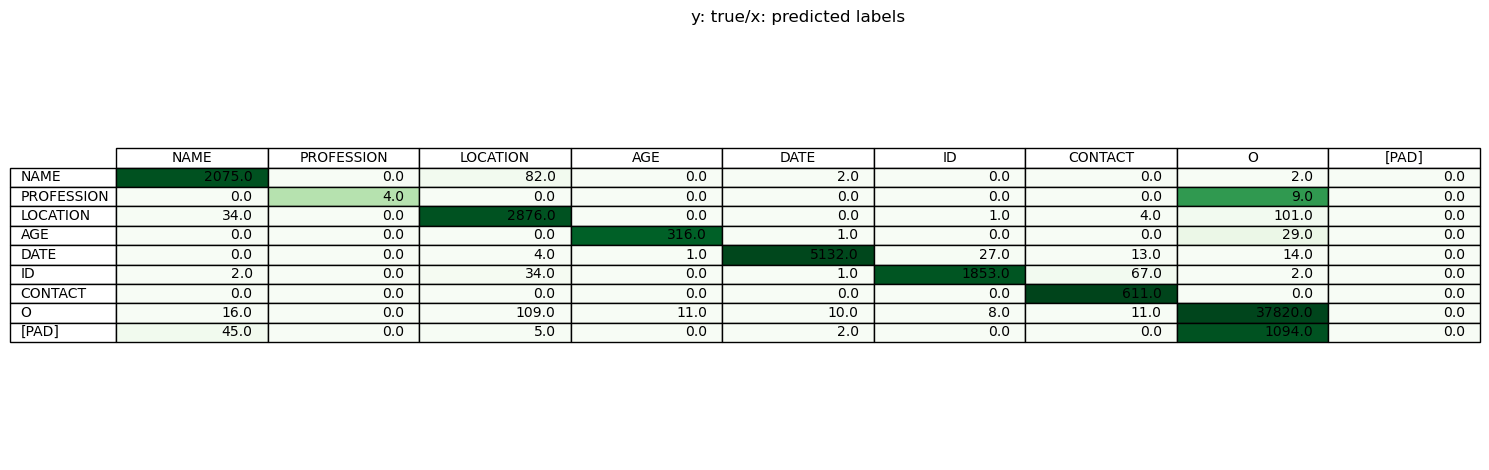

Wrongly predicted examples:
_____ Record 168-03 _____
| Sentence:    | record | date | : | april | -    | 15   | -    | 2079 | sdu | admission | note | 22   | 06   | 2035 | terrence | shannon | venice   | regional | bayfront | health   | 2334     | 5   | ym | sdu | admission | : | 16   | 04   | 1931 | pcp | : | barry | sherri | cards | : | brent | holly | chief | complaint | chest | pain | history | of | present | illness | 8   | year | old | man | with | dm1 | for | > | 40 | years | , | esrd | on | hd | , | cad | , | s | / | p | pci | at | bryan    | west     | campus   | and | sipher | stent | to | lad | ( | 100 | % | lesion | ) | on | 1925 | /    |
| True labels: | O      | O    | O | DATE  | DATE | DATE | DATE | DATE | O   | O         | O    | DATE | DATE | DATE | NAME     | NAME    | LOCATION | LOCATION | LOCATION | LOCATION | ID       | AGE | O  | O   | O         | O | DATE | DATE | DATE | O   | O | NAME  | NAME   | O     | O | NAME  | NAME  | O     | O         | O     | O    | O

In [11]:
# Метрики
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

В целом все метки предсказываются с той же точностью, что и первоначальные, за исключением метки 'CONTACT'.  
Основная трудность для модели заключается в предсказании номеров телефона, если генерировать его в российском варианте написания.
Тогда модель определяет его, как уникальный идентификатор. Проблема легко решается сменной формата номера.
Как видно, в оригинальных данных не используется код страны, и цифры сгруппированы по-другому.  
Запись **347-03**  
Original:  (121) 537-3484  
Russian format: +1 933 257-12-32  
Запись **314-02**  
Original:  (676) 312-7662  
Russian format: +1 995 672-52-24 
  
Ещё один вариант записи номера телефона в оригинальных данных: "665-578-7821"

### Этап 4: Обучение модели на анонимизированных данных

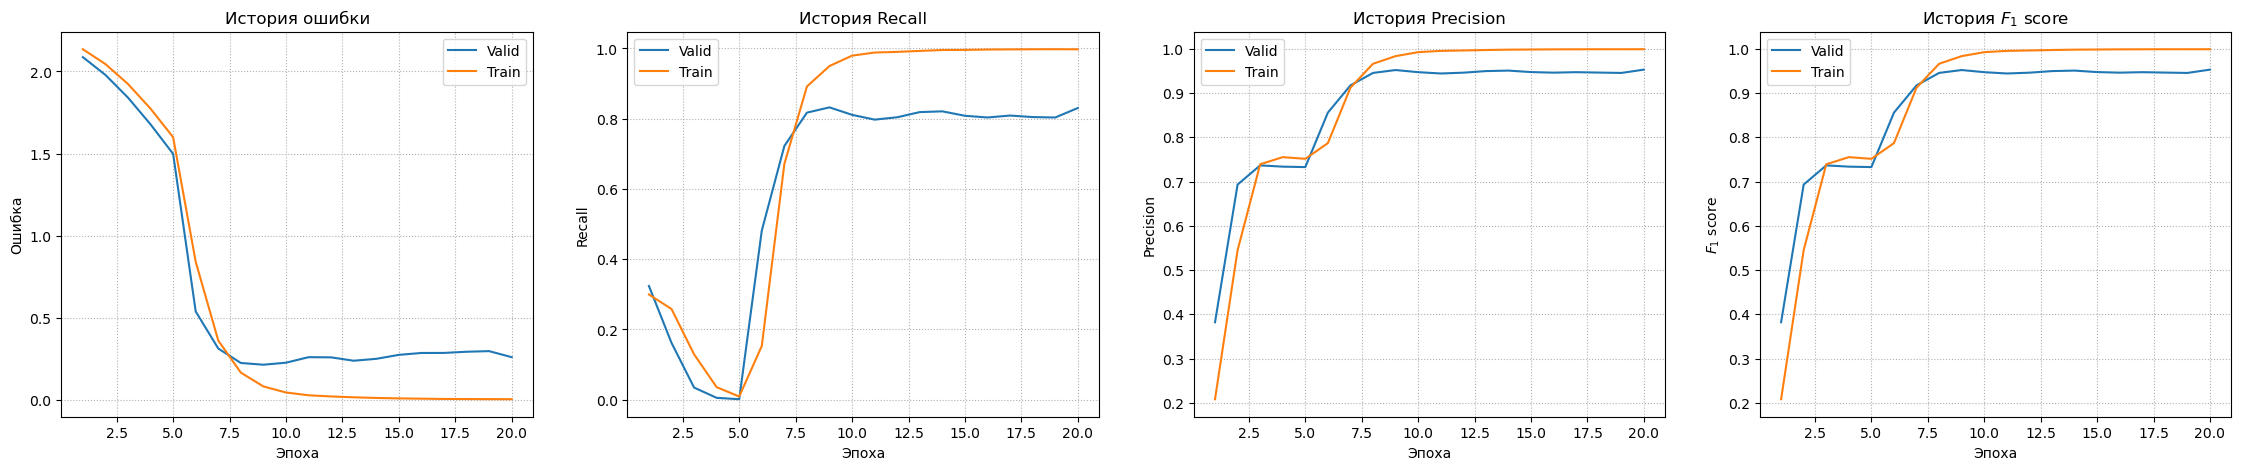

In [12]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(4)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [13]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-large-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [14]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(4)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [15]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9521142840385437
     test_precision         0.9521142840385437
       test_recall          0.8322269916534424
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.8322269916534424,
  'test_precision': 0.9521142840385437,
  'test_f1': 0.9521142840385437}]

              precision    recall  f1-score   support

        NAME     0.9583    0.6530    0.7767      3023
  PROFESSION     0.0000    0.0000    0.0000        13
    LOCATION     0.7301    0.8222    0.7734      2227
         AGE     0.9610    0.9329    0.9467       343
        DATE     0.9460    0.9783    0.9619      5715
          ID     0.8970    0.6563    0.7580      1804
     CONTACT     0.6238    0.8716    0.7271       584
           O     0.9469    0.9959    0.9708     37538

   micro avg     0.9307    0.9521    0.9413     51247
   macro avg     0.7579    0.7388    0.7393     51247
weighted avg     0.9325    0.9521    0.9391     51247



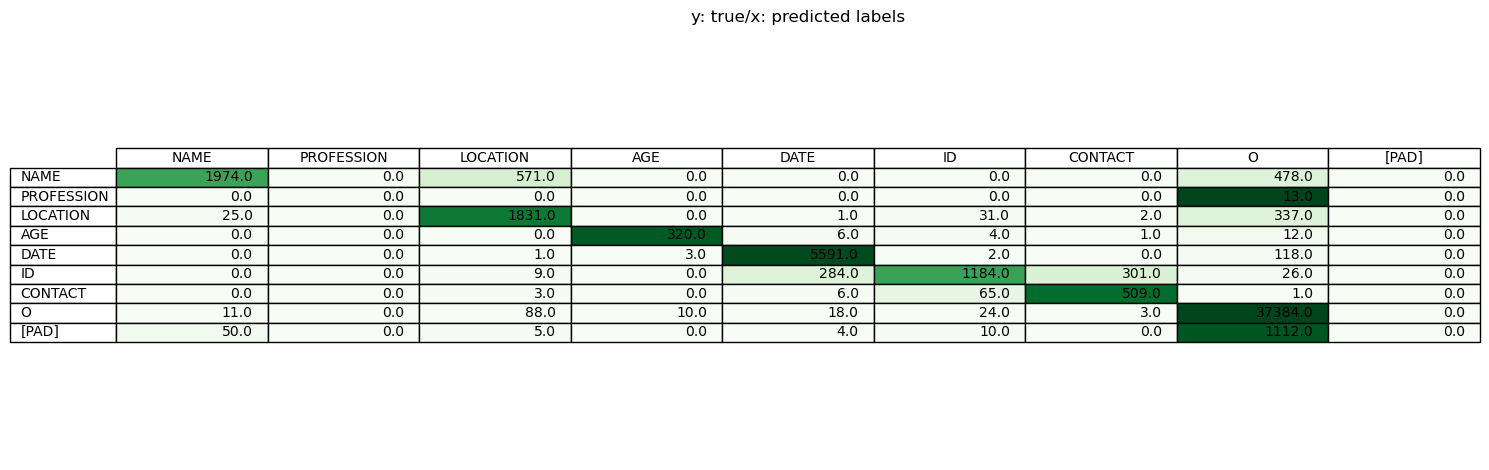

Wrongly predicted examples:
_____ Record 114-04 _____
| Sentence:    | record | date | : | 2141 | -    | 08   | -    | 31   | internal | medicine | intern | admission | note | patient | : | slater | ,    | owen | mrn | : | 8635779 | date | : | 31   | august | 41   | time | : | 816 | attending | physician | : | gregg | hcp | / | family | contact | : | talissa | irish | ( | daughter | ) | (       | 215      | )       | 579     | -       | 9664    | chief | complaint | : | hyperglycemia | history | of | the | present | illness | mr | . | slater | is | an | 83      | yo | w | / | h | / | o | bullous | pemphigoid | , | chronic | kidney | disease | , | htn | , |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | O        | O        | O      | O         | O    | O       | O | NAME   | NAME | NAME | O   | O | ID      | O    | O | DATE | DATE   | DATE | O    | O | O   | O         | O         | O | NAME  | O   | O | O      | O       | O | NAME    | NAME  | O | O        | O |

In [16]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

Самое большое паданение качества наблюдается в распознавании имён:

In [18]:
faults = stats.get_specific_failed_predictions('NAME')

Wrongly predicted examples:
_____ Record 260-04 _____
| Sentence:    | record | date | : | 2072 | -    | 11   | -    | 16   | internal | medicine | jar | admit | note | name | : | xander | vera | mr | # | : | 2152363 | date | of | admission | : | 11   | /    | 16   | /    | 2072 | attending | : | hodges | cards | fellow | : | steven | vega | pcp | : | dr | . | xavier | huerta | code | : | full | cc | : | sob | , | le | edema | hpi | : | 60  | m | with | obesity | , | dm2 | , | htn | , | hyperlipidemia | , | and | stress | test | in | 2069 | with | mild | posterobasal | reversible | defect | managed |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | O        | O        | O   | O     | O    | O    | O | NAME   | NAME | O  | O | O | ID      | O    | O  | O         | O | DATE | DATE | DATE | DATE | DATE | O         | O | NAME   | O     | O      | O | NAME   | NAME | O   | O | O  | O | NAME   | NAME   | O    | O | O    | O  | O | O   | O | O  | O     | O   | O | AGE |

In [19]:
faults = stats.get_specific_failed_predictions('ID')

Wrongly predicted examples:
_____ Record 347-01 _____
| Sentence:    | record | date | : | 2095 | -    | 08   | -    | 21   | bailey   | emergency | dept | visit | darling | ,    | betty | 785     | -       | 67      | -       | 87      | -    | 3       | resident | history | reviewed | , | the | patient | seen | , | interviewed | , | and | examined | by | me | . | history | of | presenting | complaint | : | briefly | , | the | history | is | as | follows | : | the | patient | is | a | 75  | - | year | - | old | white | female | with | past | medical | history | significant | for | throat | cancer | , | status | post | radiation | therapy | ; | breast | cancer | , | status | post | multiple | lumpectomies | ; | non | - | insulin | dependent | diabetes | mellitus | , |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | LOCATION | O         | O    | O     | NAME    | NAME | NAME  | ID      | ID      | ID      | ID      | ID      | ID   | ID      | O        | O       